In [2]:
import pandas as pd
import os

def get_base_name(filename):
    """Extrai o nome base do arquivo, removendo sufixos _A, _B, _C e .xpt"""
    name = filename.replace('.xpt', '')
    if name.endswith('_A') or name.endswith('_B') or name.endswith('_C'):
        return name[:-2]
    return name

def find_common_datasets(base_paths):
    """Encontra todos os datasets que existem nos três ciclos"""
    datasets_by_cycle = {}
    
    # Coletar nomes base de cada ciclo
    for path in base_paths:
        cycle = os.path.basename(path)
        files = [f for f in os.listdir(path) if f.lower().endswith('.xpt')]
        datasets_by_cycle[cycle] = set(get_base_name(f) for f in files)
    
    # Encontrar interseção dos conjuntos
    common_datasets = set.intersection(*datasets_by_cycle.values())
    return sorted(list(common_datasets))

def merge_dataset(base_name, base_paths):
    """Combina um dataset específico dos três ciclos"""
    dfs = []
    
    for path in base_paths:
        cycle = os.path.basename(path)
        
        # Tentar encontrar o arquivo com o padrão correto
        if cycle == 'NHANES_1999_2000':
            possible_names = [f"{base_name}.xpt", f"{base_name}_A.xpt"]
        elif cycle == 'NHANES_2001_2002':
            possible_names = [f"{base_name}_B.xpt"]
        else:  # 2003-2004
            possible_names = [f"{base_name}_C.xpt"]
        
        file_found = False
        for file_name in possible_names:
            full_path = os.path.join(path, file_name)
            if os.path.exists(full_path):
                try:
                    print(f"Lendo {file_name}")
                    df = pd.read_sas(full_path)
                    
                    # Padronizar nomes das colunas
                    df.columns = [col[:-2] if col.endswith(('_A', '_B', '_C')) else col 
                                for col in df.columns]
                    
                    df['NHANES_CYCLE'] = cycle
                    dfs.append(df)
                    print(f"Linhas: {df.shape[0]}, Colunas: {df.shape[1]}")
                    file_found = True
                    break
                except Exception as e:
                    print(f"Erro ao ler {file_name}: {str(e)}")
        
        if not file_found:
            print(f"Nenhum arquivo encontrado para {base_name} em {cycle}")
            return None
    
    if len(dfs) == 3:
        # Encontrar colunas comuns
        common_cols = set.intersection(*[set(df.columns) for df in dfs]) - {'NHANES_CYCLE'}
        columns_to_keep = list(common_cols) + ['NHANES_CYCLE']
        
        # Combinar os datasets
        combined_df = pd.concat([df[columns_to_keep] for df in dfs], 
                              axis=0, ignore_index=True)
        print(f"Dataset combinado - Linhas: {combined_df.shape[0]}, Colunas: {combined_df.shape[1]}")
        return combined_df
    return None

# Caminhos para os diretórios
base_paths = [
    '/Users/filipecarvalho/Documents/data_science_projects/PANICPRED/NHANES_1999_2000',
    '/Users/filipecarvalho/Documents/data_science_projects/PANICPRED/NHANES_2001_2002',
    '/Users/filipecarvalho/Documents/data_science_projects/PANICPRED/NHANES_2003_2004'
]

# Criar pasta para outputs
output_dir = os.path.join(os.path.dirname(base_paths[0]), 'combined_datasets')
os.makedirs(output_dir, exist_ok=True)
print(f"Arquivos combinados serão salvos em: {output_dir}")

# Encontrar todos os datasets comuns
print("\nProcurando datasets comuns aos três ciclos...")
common_datasets = find_common_datasets(base_paths)
print(f"Encontrados {len(common_datasets)} datasets comuns:")
for dataset in common_datasets:
    print(f"- {dataset}")

# Processar cada dataset
print("\nIniciando processo de merge...")
successful_merges = []
failed_merges = []

for dataset in common_datasets:
    print(f"\nProcessando {dataset}...")
    combined_df = merge_dataset(dataset, base_paths)
    
    if combined_df is not None:
        output_path = os.path.join(output_dir, f'{dataset}_combined.csv')
        combined_df.to_csv(output_path, index=False)
        successful_merges.append(dataset)
        print(f"Dataset {dataset} salvo com sucesso")
    else:
        failed_merges.append(dataset)
        print(f"Falha ao combinar dataset {dataset}")

print("\nProcessamento concluído!")
print(f"\nDatasets combinados com sucesso ({len(successful_merges)}):")
for dataset in successful_merges:
    print(f"- {dataset}")

if failed_merges:
    print(f"\nDatasets que falharam ({len(failed_merges)}):")
    for dataset in failed_merges:
        print(f"- {dataset}")

Arquivos combinados serão salvos em: /Users/filipecarvalho/Documents/data_science_projects/PANICPRED/combined_datasets

Procurando datasets comuns aos três ciclos...
Encontrados 40 datasets comuns:
- ACQ
- ALQ
- AUQ
- BAQ
- BAX
- BPQ
- CDQ
- CIQGAD
- DIQ
- DUQ
- ECQ
- HIQ
- HOQ
- HSQ
- HUQ
- IMQ
- L02HBS
- L02HPA
- LEXPN
- PAQ
- PAQIAF
- PH
- PUQ
- RDQ
- SMQFAM
- SSAMH
- SSANA2
- SSBNP
- SSCHL
- SSCMV
- SSCMVG
- SSDFS
- SSMUMP
- SSOL
- SSQ
- SSUCSH
- SSVARI
- SXQ
- UC
- VIQ

Iniciando processo de merge...

Processando ACQ...
Lendo ACQ.xpt
Linhas: 7295, Colunas: 12
Lendo ACQ_B.xpt
Linhas: 7898, Colunas: 12
Lendo ACQ_C.xpt
Linhas: 7344, Colunas: 12
Dataset combinado - Linhas: 22537, Colunas: 12
Dataset ACQ salvo com sucesso

Processando ALQ...
Lendo ALQ.xpt
Linhas: 4444, Colunas: 10
Lendo ALQ_B.xpt
Linhas: 5027, Colunas: 10
Lendo ALQ_C.xpt
Linhas: 4742, Colunas: 10
Dataset combinado - Linhas: 14213, Colunas: 9
Dataset ALQ salvo com sucesso

Processando AUQ...
Lendo AUQ.xpt
Linhas: 9493, 

In [3]:
import pandas as pd
import os

def merge_panic_data(base_paths):
    """Combina os dados de pânico dos três ciclos"""
    dfs = []
    
    # Definir os nomes específicos para cada ciclo
    file_names = {
        'NHANES_1999_2000': 'CIQPANIC.xpt',
        'NHANES_2001_2002': 'CIQPAN_B.xpt',
        'NHANES_2003_2004': 'CIQPAN_C.xpt'
    }
    
    for path in base_paths:
        cycle = os.path.basename(path)
        file_name = file_names[cycle]
        full_path = os.path.join(path, file_name)
        
        try:
            if os.path.exists(full_path):
                print(f"Lendo {file_name} do ciclo {cycle}")
                df = pd.read_sas(full_path)
                
                # Padronizar nomes das colunas (remover sufixos _B e _C)
                df.columns = [col[:-2] if col.endswith(('_B', '_C')) else col 
                            for col in df.columns]
                
                # Adicionar coluna identificando o ciclo
                df['NHANES_CYCLE'] = cycle
                
                dfs.append(df)
                print(f"Linhas: {df.shape[0]}, Colunas: {df.shape[1]}")
            else:
                print(f"Arquivo não encontrado: {full_path}")
                return None
        except Exception as e:
            print(f"Erro ao ler {file_name}: {str(e)}")
            return None
    
    if len(dfs) == 3:
        # Encontrar colunas comuns
        common_cols = set.intersection(*[set(df.columns) for df in dfs]) - {'NHANES_CYCLE'}
        columns_to_keep = list(common_cols) + ['NHANES_CYCLE']
        
        # Combinar os datasets
        combined_df = pd.concat([df[columns_to_keep] for df in dfs], 
                              axis=0, ignore_index=True)
        print(f"\nDataset combinado:")
        print(f"Linhas totais: {combined_df.shape[0]}")
        print(f"Colunas: {combined_df.shape[1]}")
        return combined_df
    return None

# Caminhos para os diretórios
base_paths = [
    '/Users/filipecarvalho/Documents/data_science_projects/SadPred/NHANES_1999_2000',
    '/Users/filipecarvalho/Documents/data_science_projects/SadPred/NHANES_2001_2002',
    '/Users/filipecarvalho/Documents/data_science_projects/SadPred/NHANES_2003_2004'
]

# Criar pasta para outputs se ainda não existir
output_dir = os.path.join(os.path.dirname(base_paths[0]), 'combined_datasets')
os.makedirs(output_dir, exist_ok=True)

print("Iniciando combinação dos dados de pânico...")
combined_df = merge_panic_data(base_paths)

if combined_df is not None:
    output_path = os.path.join(output_dir, 'PANIC_combined.csv')
    combined_df.to_csv(output_path, index=False)
    print(f"\nDataset combinado salvo em: {output_path}")
    print("\nPrimeiras colunas do dataset combinado:")
    print(list(combined_df.columns)[:5])
else:
    print("\nNão foi possível combinar os datasets de pânico")

Iniciando combinação dos dados de pânico...
Arquivo não encontrado: /Users/filipecarvalho/Documents/data_science_projects/SadPred/NHANES_1999_2000/CIQPANIC.xpt

Não foi possível combinar os datasets de pânico


In [4]:
import pandas as pd

# Caminho para o arquivo combinado
file_path = '/Users/filipecarvalho/Documents/data_science_projects/PANICPRED/combined_datasets/PANIC_combined.csv'

# Lista de variáveis para verificar
variables_to_check = [
    'CIQP44A',  # Strong Fear: Giving a speech
    'CIQP44B',  # Strong Fear: Party or social event
    'CIQP44C',  # Strong Fear: Being in a crowd
    'CIQP44D',  # Strong Fear: Meeting new people
    'CIQP44E',  # Strong Fear: Being outside, away
    'CIQP44F',  # Strong Fear: Traveling bus, train, car
    'CIQP44G',  # Strong Fear: Crowd, standing in line
    'CIQP44H'   # Strong Fear: Being in a public place
]

try:
    # Ler o dataset
    df = pd.read_csv(file_path)
    print(f"Total de colunas no dataset: {len(df.columns)}")
    print("\nVerificando variáveis específicas:")
    
    # Verificar cada variável
    for var in variables_to_check:
        if var in df.columns:
            print(f"✓ {var} - Presente")
            # Mostrar alguns valores únicos para confirmar o conteúdo
            unique_values = sorted(df[var].unique())
            print(f"   Valores únicos: {unique_values}")
        else:
            print(f"✗ {var} - Ausente")
    
    print("\nTodas as colunas disponíveis:")
    for col in sorted(df.columns):
        print(f"- {col}")

except Exception as e:
    print(f"Erro ao ler o arquivo: {str(e)}")

Total de colunas no dataset: 141

Verificando variáveis específicas:
✓ CIQP44A - Presente
   Valores únicos: [nan, 1.0]
✓ CIQP44B - Presente
   Valores únicos: [nan, 2.0]
✓ CIQP44C - Presente
   Valores únicos: [nan, 3.0]
✓ CIQP44D - Presente
   Valores únicos: [nan, 4.0]
✓ CIQP44E - Presente
   Valores únicos: [nan, 5.0]
✓ CIQP44F - Presente
   Valores únicos: [nan, 6.0]
✓ CIQP44G - Presente
   Valores únicos: [nan, 7.0]
✓ CIQP44H - Presente
   Valores únicos: [nan, 8.0]

Todas as colunas disponíveis:
- CIAORDER
- CIDPPRB
- CIDPSCOR
- CIQP01
- CIQP02
- CIQP03
- CIQP04
- CIQP05
- CIQP06
- CIQP07
- CIQP08
- CIQP09
- CIQP11
- CIQP12
- CIQP13A
- CIQP13B
- CIQP13C
- CIQP13D
- CIQP13E
- CIQP13F
- CIQP13G
- CIQP13H
- CIQP13I
- CIQP13J
- CIQP13K
- CIQP13L
- CIQP13M
- CIQP13N
- CIQP13O
- CIQP13P
- CIQP14
- CIQP15
- CIQP16
- CIQP17
- CIQP18
- CIQP19
- CIQP20
- CIQP21A
- CIQP21B
- CIQP21C
- CIQP21D
- CIQP21E
- CIQP21F
- CIQP21G
- CIQP21H
- CIQP21I
- CIQP21J
- CIQP21K
- CIQP21L
- CIQP21M
- CIQP21

In [5]:
import pandas as pd
import os

# Pasta dos datasets combinados
combined_dir = '/Users/filipecarvalho/Documents/data_science_projects/PANICPRED/combined_datasets'

# Verificar cada arquivo CSV
print("Verificando coluna SEQN em todos os datasets combinados:\n")

try:
    for file in sorted(os.listdir(combined_dir)):
        if file.endswith('_combined.csv'):
            file_path = os.path.join(combined_dir, file)
            df = pd.read_csv(file_path)
            
            # Verificar se SEQN está presente
            has_seqn = 'SEQN' in df.columns
            
            print(f"{file:30} - SEQN: {'✓ Presente' if has_seqn else '✗ Ausente'}")
            
            if has_seqn:
                # Verificar se existem valores nulos
                null_count = df['SEQN'].isnull().sum()
                if null_count > 0:
                    print(f"   Atenção: {null_count} valores nulos encontrados!")
                
                # Verificar se os valores são únicos
                unique_count = df['SEQN'].nunique()
                total_count = len(df)
                if unique_count != total_count:
                    print(f"   Atenção: {unique_count} valores únicos em {total_count} linhas")

except Exception as e:
    print(f"Erro ao processar arquivos: {str(e)}")

Verificando coluna SEQN em todos os datasets combinados:

ACQ_combined.csv               - SEQN: ✓ Presente
ALQ_combined.csv               - SEQN: ✓ Presente
AUQ_combined.csv               - SEQN: ✓ Presente
AUXAR_combined.csv             - SEQN: ✓ Presente
AUXTYM_combined.csv            - SEQN: ✓ Presente
BAQ_combined.csv               - SEQN: ✓ Presente
BAX_combined.csv               - SEQN: ✓ Presente
BIX_combined.csv               - SEQN: ✓ Presente
BMX_combined.csv               - SEQN: ✓ Presente
BPQ_combined.csv               - SEQN: ✓ Presente
BPX_combined.csv               - SEQN: ✓ Presente
CDQ_combined.csv               - SEQN: ✓ Presente
CIQGAD_combined.csv            - SEQN: ✓ Presente
CVX_combined.csv               - SEQN: ✓ Presente
DBQ_combined.csv               - SEQN: ✓ Presente
DEMO_combined.csv              - SEQN: ✓ Presente
DEQ_combined.csv               - SEQN: ✓ Presente
DIQ_combined.csv               - SEQN: ✓ Presente
DUQ_combined.csv               - SEQN: ✓ P

In [6]:
import pandas as pd
import os

def merge_all_datasets():
    # Pasta dos datasets combinados
    combined_dir = '/Users/filipecarvalho/Documents/data_science_projects/PANICPRED/combined_datasets'
    
    # Lista para armazenar todos os dataframes
    all_dfs = []
    
    print("Iniciando processo de merge...\n")
    
    # Ler cada arquivo CSV
    for file in sorted(os.listdir(combined_dir)):
        if file.endswith('_combined.csv'):
            print(f"Lendo {file}")
            df = pd.read_csv(os.path.join(combined_dir, file))
            
            # Extrair nome do dataset do nome do arquivo
            dataset_name = file.replace('_combined.csv', '')
            
            # Adicionar prefixo às colunas exceto SEQN e NHANES_CYCLE
            columns_to_rename = [col for col in df.columns if col not in ['SEQN', 'NHANES_CYCLE']]
            df = df.rename(columns={col: f"{dataset_name}_{col}" for col in columns_to_rename})
            
            print(f"- Linhas: {len(df)}")
            print(f"- Colunas: {len(df.columns)}")
            all_dfs.append(df)
    
    # Realizar o merge de todos os dataframes
    print("\nRealizando merge dos datasets...")
    final_df = all_dfs[0]
    
    for i, df in enumerate(all_dfs[1:], 1):
        print(f"\nMerge {i}")
        print(f"- Linhas antes do merge: {len(final_df)}")
        final_df = pd.merge(final_df, df, on=['SEQN', 'NHANES_CYCLE'], how='outer')
        print(f"- Linhas após o merge: {len(final_df)}")
    
    # Estatísticas finais
    print("\nEstatísticas do dataset final:")
    print(f"Total de linhas: {len(final_df)}")
    print(f"Total de colunas: {len(final_df.columns)}")
    
    # Verificar valores nulos
    null_counts = final_df.isnull().sum()
    print("\nColunas com mais valores nulos:")
    print(null_counts[null_counts > 0].sort_values(ascending=False).head())
    
    return final_df

# Executar o merge
print("Iniciando processo de merge completo...")
final_dataset = merge_all_datasets()

# Salvar o resultado
output_path = '/Users/filipecarvalho/Documents/data_science_projects/SadPred/NHANES_complete.csv'
final_dataset.to_csv(output_path, index=False)
print(f"\nDataset completo salvo em: {output_path}")

# Mostrar primeiras linhas
print("\nPrimeiras linhas do dataset final:")
print(final_dataset.head())

Iniciando processo de merge completo...
Iniciando processo de merge...

Lendo ACQ_combined.csv
- Linhas: 22537
- Colunas: 12
Lendo ALQ_combined.csv
- Linhas: 14213
- Colunas: 9
Lendo AUQ_combined.csv
- Linhas: 29608
- Colunas: 14
Lendo AUXAR_combined.csv
- Linhas: 5742
- Colunas: 339
Lendo AUXTYM_combined.csv
- Linhas: 5742
- Colunas: 171
Lendo BAQ_combined.csv
- Linhas: 9970
- Colunas: 25
Lendo BAX_combined.csv
- Linhas: 7281
- Colunas: 23
Lendo BIX_combined.csv
- Linhas: 16589
- Colunas: 116
Lendo BMX_combined.csv
- Linhas: 29402
- Colunas: 27
Lendo BPQ_combined.csv
- Linhas: 18891
- Colunas: 31
Lendo BPX_combined.csv
- Linhas: 29402
- Colunas: 31
Lendo CDQ_combined.csv
- Linhas: 9970
- Colunas: 3
Lendo CIQGAD_combined.csv
- Linhas: 2556
- Colunas: 71
Lendo CVX_combined.csv
- Linhas: 14417
- Colunas: 67
Lendo DBQ_combined.csv
- Linhas: 31126
- Colunas: 12
Lendo DEMO_combined.csv
- Linhas: 31126
- Colunas: 35
Lendo DEQ_combined.csv
- Linhas: 15087
- Colunas: 2
Lendo DIQ_combined.csv
-

In [7]:
import pandas as pd

# Ler o dataset de pânico para obter os SEQNs
panic_df = pd.read_csv('/Users/filipecarvalho/Documents/data_science_projects/PANICPRED/combined_datasets/PANIC_combined.csv')

# Obter lista única de SEQNs do dataset de pânico
panic_seqns = set(panic_df['SEQN'])
print(f"Número de SEQNs únicos no dataset de pânico: {len(panic_seqns)}")

# Ler o dataset completo
complete_df = pd.read_csv('/Users/filipecarvalho/Documents/data_science_projects/SadPred/NHANES_complete.csv')
print(f"Número de linhas no dataset completo: {len(complete_df)}")

# Criar subset usando apenas os SEQNs do dataset de pânico
subset_df = complete_df[complete_df['SEQN'].isin(panic_seqns)]
print(f"Número de linhas no subset final: {len(subset_df)}")

# Verificar se mantivemos todos os SEQNs do panic
final_seqns = set(subset_df['SEQN'])
missing_seqns = panic_seqns - final_seqns
if missing_seqns:
    print(f"\nAtenção: {len(missing_seqns)} SEQNs do dataset de pânico não foram encontrados no dataset completo")
else:
    print("\nTodos os SEQNs do dataset de pânico foram mantidos no subset")

# Salvar o subset
output_path = '/Users/filipecarvalho/Documents/data_science_projects/SadPred/NHANES_panic_subset.csv'
subset_df.to_csv(output_path, index=False)
print(f"\nSubset salvo em: {output_path}")

# Mostrar algumas estatísticas do subset
print("\nEstatísticas do subset:")
print(f"Número de colunas: {len(subset_df.columns)}")
print("\nDistribuição por ciclo:")
print(subset_df['NHANES_CYCLE'].value_counts())

Número de SEQNs únicos no dataset de pânico: 2556
Número de linhas no dataset completo: 83223
Número de linhas no subset final: 6581

Todos os SEQNs do dataset de pânico foram mantidos no subset

Subset salvo em: /Users/filipecarvalho/Documents/data_science_projects/SadPred/NHANES_panic_subset.csv

Estatísticas do subset:
Número de colunas: 1818

Distribuição por ciclo:
NHANES_CYCLE
NHANES_2001_2002    2590
NHANES_2003_2004    2364
NHANES_1999_2000    1627
Name: count, dtype: int64


In [8]:
import pandas as pd
import numpy as np

# Ler o dataset
df = pd.read_csv("/Users/filipecarvalho/Documents/data_science_projects/PanicPred/NHANES_panic_subset.csv")

# Criar a variável target baseada em CIQGAD_CIDGSCOR = 1
df['target'] = (df['PANIC_CIDPSCOR'] == 1).astype(int)

# Calcular estatísticas gerais
total = len(df)
positivos = df['target'].sum()
negativos = total - positivos

print("Estatísticas da variável target (PANIC_CIDPSCOR = 1):")
print(f"Total de observações: {total}")
print(f"Casos positivos: {positivos} ({(positivos/total)*100:.2f}%)")
print(f"Casos negativos: {negativos} ({(negativos/total)*100:.2f}%)")

# Análise por ciclo
print("\nDistribuição por ciclo NHANES:")
for cycle in df['NHANES_CYCLE'].unique():
    cycle_df = df[df['NHANES_CYCLE'] == cycle]
    cycle_pos = cycle_df['target'].sum()
    cycle_total = len(cycle_df)
    print(f"\n{cycle}:")
    print(f"Total: {cycle_total}")
    print(f"Positivos: {cycle_pos} ({(cycle_pos/cycle_total)*100:.2f}%)")

# Salvar o dataset com a nova variável target
df.to_csv('/Users/filipecarvalho/Documents/data_science_projects/PANICPRED/NHANES_panic_subset_with_target.csv', index=False)

Estatísticas da variável target (PANIC_CIDPSCOR = 1):
Total de observações: 6581
Casos positivos: 178 (2.70%)
Casos negativos: 6403 (97.30%)

Distribuição por ciclo NHANES:

NHANES_1999_2000:
Total: 1627
Positivos: 59 (3.63%)

NHANES_2001_2002:
Total: 2590
Positivos: 62 (2.39%)

NHANES_2003_2004:
Total: 2364
Positivos: 57 (2.41%)



Distribuição de MCQ_MCQ250C:
MCQ_MCQ250C
2.0    4643
1.0    1938
Name: count, dtype: int64

Distribuição de MCQ_MCQ250F:
MCQ_MCQ250F
2.0    3958
1.0    2623
Name: count, dtype: int64

Distribuição de DEMO_INDHHINC:
DEMO_INDHHINC
11.0    1551
6.0      896
8.0      667
7.0      543
NaN      538
9.0      504
10.0     436
5.0      373
2.0      325
3.0      311
4.0      304
1.0      133
Name: count, dtype: int64

Distribuição de MCQ_MCQ250A:
MCQ_MCQ250A
1.0    3414
2.0    3167
Name: count, dtype: int64

Distribuição de SMQ_SMQ040:
SMQ_SMQ040
NaN    3975
1.0    1246
3.0     917
2.0     443
Name: count, dtype: int64

Distribuição de BPQ_BPQ020:
BPQ_BPQ020
2.0    5739
1.0     766
NaN      76
Name: count, dtype: int64

Distribuição de BPQ_BPQ060:
BPQ_BPQ060
1.0    3424
2.0    3157
Name: count, dtype: int64

Distribuição de DEMO_DMDEDUC:
DEMO_DMDEDUC
3.0    3965
2.0    1491
1.0    1125
Name: count, dtype: int64

Distribuição de BPQ_BPQ040D:
BPQ_BPQ040D
NaN    5815
1.0     408
2.0     358
Name: 

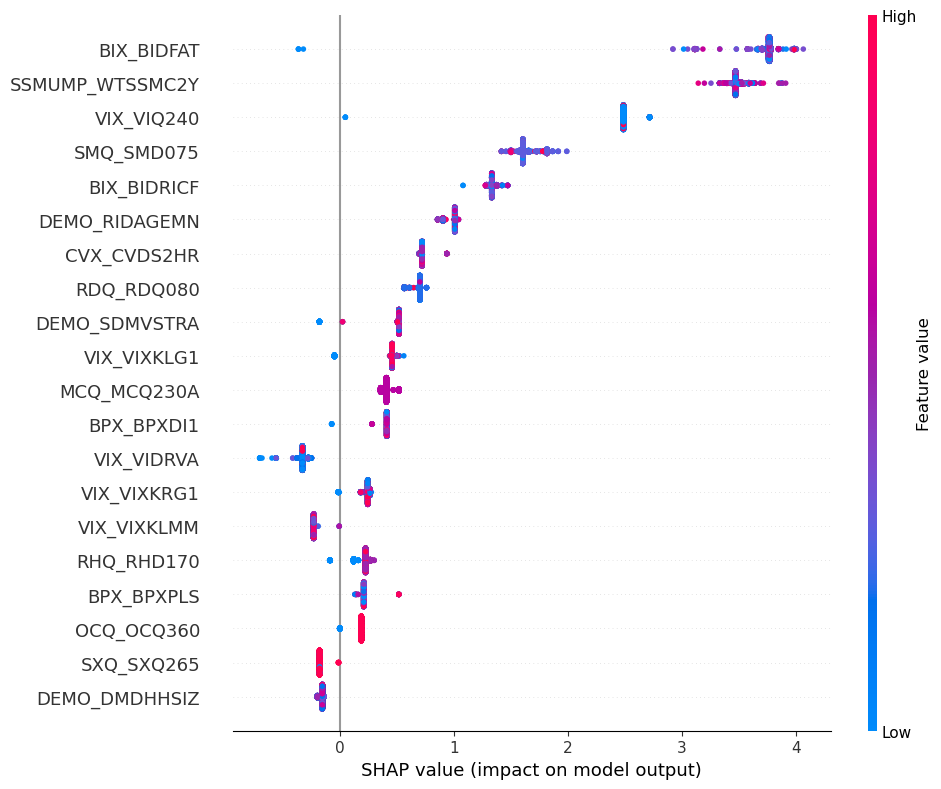

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import shap
import random

# Ler dados
df = pd.read_csv('NHANES_panic_subset_with_target.csv')

# Variáveis a tratar como categóricas
categorical_vars = ['MCQ_MCQ250C', 'MCQ_MCQ250F', 'DEMO_INDHHINC', 'MCQ_MCQ250A', 
                   'SMQ_SMQ040', 'BPQ_BPQ020', 'BPQ_BPQ060', 'DEMO_DMDEDUC', 
                   'BPQ_BPQ040D', 'MCQ_MCQ160A', 'ALQ_ALQ150', 'PAQ_PAD320']

# Funções auxiliares para comparação segura
def safe_comparison(series, value):
    return pd.to_numeric(series, errors='coerce') == value

def safe_isin(series, values):
    return pd.to_numeric(series, errors='coerce').isin(values)

# Substituições
df.loc[safe_comparison(df['MCQ_MCQ250C'], 9), 'MCQ_MCQ250C'] = 2
df.loc[safe_isin(df['MCQ_MCQ250F'], [7, 9]), 'MCQ_MCQ250F'] = 2
df.loc[safe_isin(df['MCQ_MCQ250A'], [7, 9]), 'MCQ_MCQ250A'] = 2

# DEMO_INDHHINC
df.loc[safe_comparison(df['DEMO_INDHHINC'], 13), 'DEMO_INDHHINC'] = [
    random.randint(1,4) for _ in range(len(df[safe_comparison(df['DEMO_INDHHINC'], 13)]))
]
df.loc[safe_comparison(df['DEMO_INDHHINC'], 12), 'DEMO_INDHHINC'] = [
    random.randint(5,11) for _ in range(len(df[safe_comparison(df['DEMO_INDHHINC'], 12)]))
]
df.loc[safe_isin(df['DEMO_INDHHINC'], [77, 99]), 'DEMO_INDHHINC'] = np.nan

df.loc[safe_isin(df['BPQ_BPQ020'], [7, 9]), 'BPQ_BPQ020'] = 2
df.loc[safe_isin(df['BPQ_BPQ060'], [7, 9]), 'BPQ_BPQ060'] = 2

df.loc[safe_isin(df['DEMO_DMDEDUC'], [7, 9]), 'DEMO_DMDEDUC'] = [
    random.randint(1,3) for _ in range(len(df[safe_isin(df['DEMO_DMDEDUC'], [7, 9])]))
]

df.loc[safe_isin(df['BPQ_BPQ040D'], [7, 9]), 'BPQ_BPQ040D'] = 2
df.loc[safe_isin(df['MCQ_MCQ160A'], [7, 9]), 'MCQ_MCQ160A'] = 2
df.loc[safe_isin(df['ALQ_ALQ150'], [7, 9]), 'ALQ_ALQ150'] = 2
df.loc[safe_comparison(df['PAQ_PAD320'], 3), 'PAQ_PAD320'] = np.nan

# Ver distribuições
for var in categorical_vars:
    print(f"\nDistribuição de {var}:")
    print(df[var].value_counts(dropna=False))

print("\nDistribuição inicial por género e target:")
print(pd.crosstab(df['DEMO_RIAGENDR'], df['target']))

# Pré-processamento
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

df_processed = df.copy()

# Imputar numéricas
for col in numeric_cols:
    df_processed[col] = SimpleImputer(strategy='median').fit_transform(df_processed[[col]])

# Imputar e codificar categóricas
label_encoders = {}
for col in categorical_cols:
    df_processed[col] = df_processed[col].fillna('missing')
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le

# Variáveis a remover
bix_vars_to_remove = [  # (mesma lista longa do teu código)
    'BIX_BIXC245K', 'BIX_BIXC339K', 'BIX_BIXC083K', "BIX_BIXC200K", "BIX_BIXC067K","BIX_BIXC378K",
    "BIX_BIXC159K", "BIX_BIXC012K", "BIX_BIXC054K", "BIX_BIXC421K", "BIX_BIXC060K", "BIX_BIXC100K",
    "BIX_BIXC128K", "BIX_BIXC075K", "BIX_BIXC469K", "BIX_BIXC093K", "BIX_BIXC177K", "BIX_BIXC115K",
    "BIX_BIXC013K", "BIX_BIXC016K", "BIX_BIXC143K", "BIX_BIXC035K", "BIX_BIXC014K", "BIX_BIXC028K",
    "BIX_BIXC015K", "BIX_BIXC043K", "BIX_BIXC018K", "BIX_BIXC011K", "BIX_BIXC220K", "BIX_BIXC273K",
    "BIX_BIXC500K", "BIX_BIXC050K","CIQGAD_CIQG02", "BIX_BIXC020K", "BIX_BIXC806K", "BIX_BIXS005K", 
    "BIX_BIXC031K", "BIX_BIXC025K", "BIX_BIXC009K", "BIX_BIXC023K", "BIX_BIXC649K", "BIX_BIXC304K", 
    "BIX_BIXC723K","BIX_BIXC582K","BIX_BIXS013K", "BIX_BIDICF", "BIX_BIXC898K", "MPQ_MPD040","MPQ_MPQ020",
    "MCQ_MCQ180K", "CIQGAD_CIDGSCOR" ,"MPQ_MPQ100","CIQGAD_CIQG01", "CIQGAD_CIQG05","CIQGAD_CIQG33",
    "CIQGAD_CIQG15", "CIQGAD_CIQG03", "CIQGAD_CIQG23", "CIQGAD_CIQG30", "CIQGAD_CIQG29", "CIQGAD_CIQG26",
    "CIQGAD_CIQG16", "CIQGAD_CIQG06", "CIQGAD_CIQG04", "CIQGAD_CIQG20", "RXQ_RX_RXDDRGID", "HUQ_HUQ090",
    "CIQGAD_CIQG28", "CIQGAD_CIQG38", "CIQGAD_CIQG24", "CIQGAD_CIQG35", "CIQGAD_CIQG17G", "CIQGAD_CIQG12",
    "CIQGAD_CIQG36", "CIQGAD_CIQG09", "BIX_BIXC039K", "BIX_BIXS016K", "HUQ_HUQ050", "CIQGAD_CIQG25",
    "HUQ_HUQ010", "HSQ_HSQ520", "BPQ_BPQ040B", "MPQ_MPQ110", "MCQ_MCQ245A", "HIQ_HIQ220", "AUQ_AUQ190",
    "SSMUMP_SSISR", "AUQ_AUQ200", "CIQGAD_CIQG08", "PFQ_PFQ059", "BIX_BIDTD", "DEMO_DMDHRAGE",
    "DEMO_DMDHREDU", "ALQ_ALQ110", "BIX_BIDFIT", "BPQ_BPQ040C", "DEMO_DMDHRBRN", "HUQ_HUQ030",
    "RDQ_RDQ070", "RHQ_RHD080", "RHQ_RHQ210", "RHQ_RHQ250", "BIX_BIXC1M", "CVX_CVDR3HR", "OCQ_OCQ380",
    "SMQ_SMD100TR", "RHQ_RHQ190", "RHQ_RHQ160", "CVX_CVDEXCL2", "HSQ_HSQ500", "OCQ_OCQ260", "PAQ_PAQ500",
    "DEMO_SDDSRVYR", "RHQ_RHQ460Q", "UC_URXPREG", "CVX_CVDR3SY", "SMQ_SMD100BR", "BIX_BIDFC", "BPX_BPXSY3",
    "SMQ_SMD100CO", "MCQ_MCQ245B", "BPX_BPXSAR", "SMQ_SMD100LN", "VIX_VIXKLM2", "SMQ_SMD100NI", "VIX_VIXPLS",
    "SMQ_SMD130", "BIX_BIDECF", "BIX_BIAEXSTS", "BPX_BPXSY2", "RHQ_RHQ460U", "SMQ_SMD100MN", "BIX_BIDTBW",
    "FSQ_FSD170N", "RHQ_RHQ430", "HUQ_HUQ020", "OCQ_OCD395", "BMX_BMXWAIST", "HSQ_HSQ510", "MPQ_MPQ060",
    "HOQ_HOD050", "VIX_VIXPRC", "OHQ_OHQ033", "CVX_CVDEXLEN", "BIX_BIDALPHA", "SMQFAM_SMD430", "BIX_BIXS031K",
    "DIQ_DIQ060U", "VIX_VIXOLSM", "DEMO_RIDEXPRG", "RHQ_RHQ564", "RDQ_RDQ137", "DEMO_DMDHRGND", "OHXREF_OHAEXSTS",
    "CIQGAD_CIQG10", "OCQ_OCD230", "OHQ_OHQ030", "BPX_BPXDI4", "HOQ_HOD030", "PH_PHACOFHR", "RHQ_RHQ568Q",
    "DIQ_DIQ050", "DEMO_RIDEXMON", "WHQ_WHQ030", "AUQ_AUQ210", "CVX_CVAPROT", "PH_PHACOFMN", "BPQ_BPQ040F",
    "OHXREF_OHQ134", "CVX_CVDPROT", "VIX_VIXORAM", "OHXREF_OHQ132", "OCQ_OCD480", "BIX_BIXC005K", "BPX_BPXSY4",
    "SXQ_SXQ100", "CIQGAD_CIQG32", "RDQ_RDQ135", "PAQ_PAD080", "VIX_VIDROVA", "CVX_CVDS2SY", "MCQ_MCQ180A",
    "OSQ_OSD030BA", "RHQ_RHQ390", "SMQ_SMD190", "RHQ_RHQ420", "RHQ_RHQ330", "PH_PHAFSTHR", "RHQ_RHQ180",
    "MPQ_MPQ090", "DEMO_WTMEC2YR", "DEMO_RIDAGEEX", "BIX_BIXS025K", "VIX_VIXKLM1", "VIX_VIXKRM1",
    "CIQGAD_WTSCI2YR", "BIX_BIDPFAT", "VIX_VIXOLCM", "BIX_BIXS035K", "BIX_BIXS039K", "VIX_VIXORCM"
]

# Remover colunas
columns_to_drop = [col for col in df.columns if 'PANIC_' in col] + ['SEQN'] + bix_vars_to_remove
X = df_processed.drop(columns_to_drop + ['target'], axis=1)
y = df_processed['target']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Pipeline SEM SMOTE
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(
        n_estimators=200,
        max_depth=5,
        random_state=42,
        min_samples_leaf=1,
        min_samples_split=4,
        learning_rate=0.1
    ))
])

# Treino
pipeline.fit(X_train, y_train)

# Predição
y_pred = pipeline.predict(X_test)

# Métricas
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# SHAP
model = pipeline.named_steps['classifier']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    shap_values = shap_values[1]  # classe positiva

feature_importance = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 30 features (SHAP):")
print(shap_df.head(30))

# Guardar
shap_df.to_csv('shap_importance_gb_no_smote.csv', index=False)
shap.summary_plot(shap_values, X_test, plot_size=(10,8))

# Guardar dados processados
df.to_csv('NHANES_panic_subset_with_target_modified.csv', index=False)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2242
         1.0       0.96      0.81      0.88        62

    accuracy                           0.99      2304
   macro avg       0.98      0.90      0.94      2304
weighted avg       0.99      0.99      0.99      2304


Top features (importância):
            feature    importance
3        BIX_BIDFAT  1.836230e-01
10       WHQ_WHD050  1.726055e-01
9      BPX_PEASCTM1  1.586932e-01
0        WHQ_WHD120  9.524655e-02
4     DEMO_RIDAGEMN  5.277677e-02
11    DEMO_INDFMPIR  5.175772e-02
16       ALQ_ALQ130  5.096424e-02
5        BMX_BMXTRI  4.915708e-02
17       BMX_BMXBMI  4.820051e-02
13    DEMO_DMDHHSIZ  4.604430e-02
7        SXQ_SXQ250  2.144670e-02
6   PAQIAF_PADLEVEL  1.408449e-02
1      CVX_CVDEXSTS  1.376542e-02
18       IMQ_IMQ020  1.245816e-02
15       MPQ_MPQ070  1.103169e-02
20    DEMO_DMDMARTL  9.504667e-03
8        BPQ_BPQ010  6.233466e-03
2       

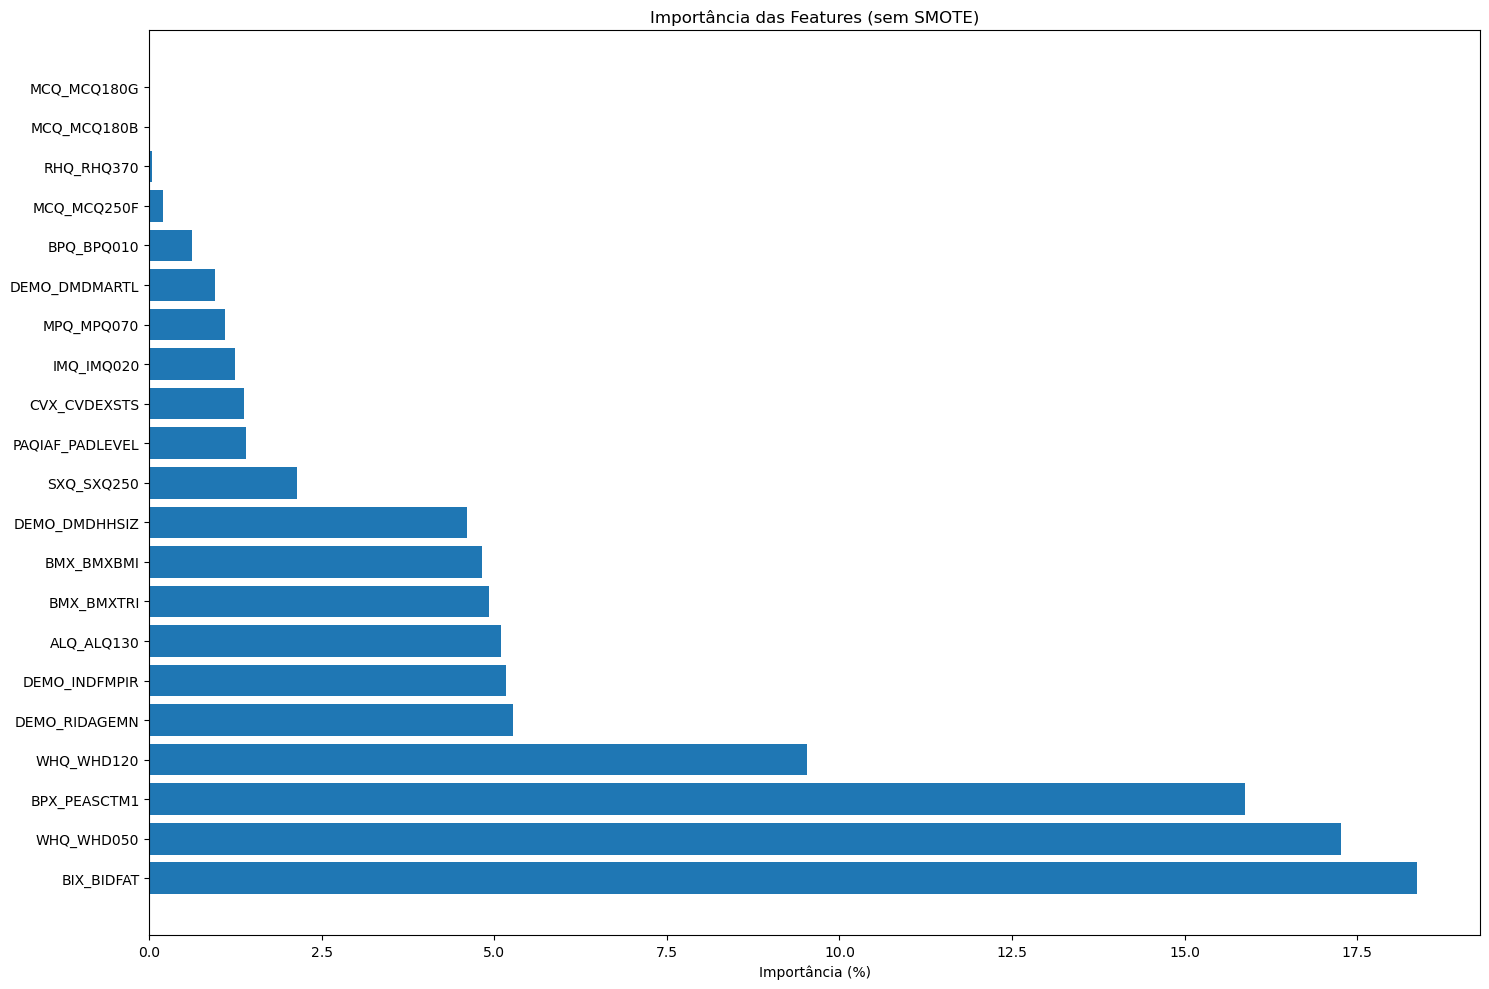

<Figure size 1000x700 with 0 Axes>

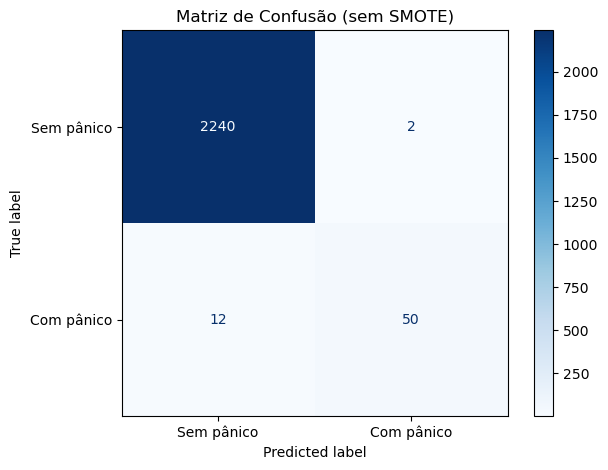

In [10]:
######## SEM SMOTE ##########

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Ler importância e selecionar top 30
importance_df = pd.read_csv('shap_importance_gb.csv')
top_23_features = importance_df.head(30)['feature'].tolist()

# Garantir que DEMO_RIAGENDR está nas features
features_for_model = top_23_features.copy()
if 'DEMO_RIAGENDR' not in features_for_model:
    features_for_model.append('DEMO_RIAGENDR')

# Ler dataset
df = pd.read_csv('NHANES_panic_subset_with_target_modified.csv')

# Pré-processamento
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

df_processed = df.copy()

# Imputar numéricas
for col in numeric_cols:
    df_processed[col] = SimpleImputer(strategy='median').fit_transform(df_processed[[col]])

# Imputar e codificar categóricas
for col in categorical_cols:
    df_processed[col] = df_processed[col].fillna('missing')
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))

# Selecionar features
X = df_processed[features_for_model]
y = df_processed['target']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, stratify=y, random_state=42
)

# Remover colunas extras (se aplicável)
cols_to_drop = ["OCQ_OCD390", "SXQ_SXQ020", "MCQ_MCQ250C", "AUQ_AUQ130",
                "BPQ_BPQ040D", "MCQ_MCQ230A", "PH_PHAFSTMN", "BMX_BMXSUB", "AUQ_AUQ220"]

if 'DEMO_RIAGENDR' not in top_23_features:
    cols_to_drop.append('DEMO_RIAGENDR')

X_train_final = X_train.drop(columns=[c for c in cols_to_drop if c in X_train.columns], errors='ignore')
X_test_final = X_test.drop(columns=[c for c in cols_to_drop if c in X_test.columns], errors='ignore')

# Pipeline SEM SMOTE
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(
        n_estimators=200,
        max_depth=8,
        random_state=42,
        min_samples_leaf=1,
        min_samples_split=4,
        learning_rate=0.1
    ))
])

# Treino
pipeline.fit(X_train_final, y_train)

# Predição
y_pred = pipeline.predict(X_test_final)

# Métricas
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Importância
model = pipeline.named_steps['classifier']
importance_df_new = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop features (importância):")
print(importance_df_new)

# Salvar
importance_df_new.to_csv('feature_importance_gb_new_no_smote.csv', index=False)

# Gráfico de importância
plt.figure(figsize=(15, 10))
plt.barh(range(len(importance_df_new)), importance_df_new['importance'] * 100)
plt.yticks(range(len(importance_df_new)), importance_df_new['feature'])
plt.xlabel('Importância (%)')
plt.title('Importância das Features (sem SMOTE)')
plt.tight_layout()
plt.savefig('feature_importance_no_smote.png')
plt.show()

# Matriz de confusão
plt.figure(figsize=(10,7))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem pânico', 'Com pânico'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão (sem SMOTE)')
plt.tight_layout()
plt.savefig('confusion_matrix_no_smote.png')
plt.show()

In [11]:
df["target"].value_counts()

target
0    6403
1     178
Name: count, dtype: int64

In [12]:
import pandas as pd
import numpy as np

# Carregar o dataset
df = pd.read_csv('NHANES_panic_subset_with_target_modified.csv')

# Mapeamentos para variáveis categóricas
category_maps = {
    'DEMO_RIAGENDR': {1: 'Male', 2: 'Female'},
    'DEMO_DMDEDUC': {
        1: 'Less Than High School', 
        2: 'High School Diploma', 
        3: 'More Than High School'
    },
    'DEMO_INDHHINC': {
        1: '$0 to $4,999',  # Combina 1 e 2
        3: '$5,000 to $9,999',  # Combina 3 e 4
        5: '$10,000 to $14,999',  # Combina 5 e 6
        7: '$15,000 to $19,999',  # Combina 7 e 8
        11: '$20,000 to $34,999',  # Usa categoria existente
        12: '$35,000 to $54,999',  # Combina algumas categorias
        16: '$55,000 and Over'  # Mantém categoria existente
    }
}

# Função para calcular estatísticas com percentagens dentro do grupo
def calculate_group_stats(df, var, is_categorical=False):
    # Converter coluna para tipo categórico, tratando NaNs
    if is_categorical:
        # Filtrar categorias indesejadas para variáveis específicas
        if var == 'DEMO_DMDEDUC':
            df = df[df[var].isin([1, 2, 3])]
        elif var == 'DEMO_INDHHINC':
            # Mapear valores para novos intervalos
            income_mapping = {
                1: '$0 to $4,999',
                2: '$0 to $4,999',
                3: '$5,000 to $9,999',
                4: '$5,000 to $9,999',
                5: '$10,000 to $14,999',
                6: '$10,000 to $14,999',
                7: '$15,000 to $19,999',
                8: '$15,000 to $19,999',
                9: '$20,000 to $34,999',
                10: '$20,000 to $34,999',
                11: '$20,000 to $34,999',
                12: '$35,000 to $54,999',
                13: '$35,000 to $54,999',
                14: '$35,000 to $54,999',
                15: '$55,000 and Over',
                16: '$55,000 and Over'
            }
            df['DEMO_INDHHINC_grouped'] = df['DEMO_INDHHINC'].map(income_mapping)
            var = 'DEMO_INDHHINC_grouped'
        
        # Converter para categoria, tratando NaNs
        df[var] = df[var].fillna('Unknown').astype('category')
        
        # Contagem total e percentagem global
        total_counts = df[var].value_counts()
        total_percents = total_counts / len(df) * 100
        
        # Estatísticas para grupo normal
        normal_counts = df[df['target'] == 0][var].value_counts()
        normal_percents = normal_counts / len(df[df['target'] == 0]) * 100
        
        # Estatísticas para grupo com pânico
        panic_counts = df[df['target'] == 1][var].value_counts()
        panic_percents = panic_counts / len(df[df['target'] == 1]) * 100
        
        # Combinar resultados
        results = []
        for category in df[var].cat.categories:
            # Mapear código numérico para label descritiva
            category_label = category_maps.get(var, {}).get(category, str(category))
            results.append([
                category_label,
                f"{total_counts.get(category, 0)} ({total_percents.get(category, 0):.1f}%)",
                f"{normal_counts.get(category, 0)} ({normal_percents.get(category, 0):.1f}%)",
                f"{panic_counts.get(category, 0)} ({panic_percents.get(category, 0):.1f}%)"
            ])
        return results
    else:
        # Para variáveis contínuas
        total_mean = df[var].mean()
        total_std = df[var].std()
        
        normal_mean = df[df['target'] == 0][var].mean()
        normal_std = df[df['target'] == 0][var].std()
        
        panic_mean = df[df['target'] == 1][var].mean()
        panic_std = df[df['target'] == 1][var].std()
        
        return [
            f"{total_mean:.1f} ± {total_std:.1f}",
            f"{normal_mean:.1f} ± {normal_std:.1f}",
            f"{panic_mean:.1f} ± {panic_std:.1f}"
        ]

# Variáveis a analisar
continuous_vars = {
    'DEMO_RIDAGEEX': 'Age (years)',
    'BMX_BMXWT': 'Weight (kg)',
    'BMX_BMXHT': 'Height (cm)',
    'BMX_BMXBMI': 'BMI'
}

categorical_vars = {
    'DEMO_RIAGENDR': 'Gender',
    'DEMO_DMDEDUC': 'Education Level',
    'DEMO_INDHHINC': 'Household Income'
}

# Gerar resultados
print("Population Characteristics:")

# Variáveis contínuas
for var, label in continuous_vars.items():
    if var == 'DEMO_RIDAGEEX':
        # Converter de meses para anos
        df[var] = df[var] / 12
    
    stats = calculate_group_stats(df, var)
    print(f"\n{label}:")
    print(f"Total: {stats[0]}")
    print(f"Normal: {stats[1]}")
    print(f"Panic Group: {stats[2]}")

# Variáveis categóricas
for var, label in categorical_vars.items():
    print(f"\n{label}:")
    results = calculate_group_stats(df, var, is_categorical=True)
    for row in results:
        print(row)

# Estatísticas adicionais
print("\nAdditional Statistics:")
print(f"Total Sample Size: {len(df)}")
print(f"Normal Group Size: {len(df[df['target'] == 0])}")
print(f"Panic Group Size: {len(df[df['target'] == 1])}")
print(f"Panic Group Prevalence: {len(df[df['target'] == 1])/len(df)*100:.2f}%")

Population Characteristics:

Age (years):
Total: 29.6 ± 5.8
Normal: 29.5 ± 5.8
Panic Group: 31.1 ± 4.7

Weight (kg):
Total: 79.8 ± 22.5
Normal: 79.8 ± 22.6
Panic Group: 79.1 ± 20.4

Height (cm):
Total: 169.1 ± 9.8
Normal: 169.3 ± 9.9
Panic Group: 164.7 ± 6.2

BMI:
Total: 27.8 ± 7.1
Normal: 27.8 ± 7.1
Panic Group: 29.1 ± 7.2

Gender:
['Male', '2956 (44.9%)', '2922 (45.6%)', '34 (19.1%)']
['Female', '3625 (55.1%)', '3481 (54.4%)', '144 (80.9%)']

Education Level:
['Less Than High School', '1125 (17.1%)', '1080 (16.9%)', '45 (25.3%)']
['High School Diploma', '1491 (22.7%)', '1433 (22.4%)', '58 (32.6%)']
['More Than High School', '3965 (60.2%)', '3890 (60.8%)', '75 (42.1%)']

Household Income:
['$0 to $4,999', '458 (7.0%)', '412 (6.4%)', '46 (25.8%)']
['$10,000 to $14,999', '1269 (19.3%)', '1227 (19.2%)', '42 (23.6%)']
['$15,000 to $19,999', '1210 (18.4%)', '1196 (18.7%)', '14 (7.9%)']
['$20,000 to $34,999', '2491 (37.9%)', '2435 (38.0%)', '56 (31.5%)']
['$5,000 to $9,999', '615 (9.3%)', '

In [13]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Carregar o dataset
df = pd.read_csv('NHANES_panic_subset_with_target_modified.csv')

# Função para calcular estatísticas com percentagens dentro do grupo
def calculate_group_stats(df, var, is_categorical=False):
    # Estatísticas para todo o dataset
    total_stats = []
    
    if is_categorical:
        # Contagem total e percentagem global
        total_counts = df[var].value_counts()
        total_percents = total_counts / len(df) * 100
        
        # Estatísticas para grupo normal
        normal_counts = df[df['target'] == 0][var].value_counts()
        normal_percents = normal_counts / len(df[df['target'] == 0]) * 100
        
        # Estatísticas para grupo com pânico
        panic_counts = df[df['target'] == 1][var].value_counts()
        panic_percents = panic_counts / len(df[df['target'] == 1]) * 100
        
        # Combinar resultados
        results = []
        for category in sorted(df[var].unique()):
            results.append([
                f"{category}",
                f"{total_counts.get(category, 0)} ({total_percents.get(category, 0):.1f}%)",
                f"{normal_counts.get(category, 0)} ({normal_percents.get(category, 0):.1f}%)",
                f"{panic_counts.get(category, 0)} ({panic_percents.get(category, 0):.1f}%)"
            ])
        return results
    else:
        # Para variáveis contínuas
        total_mean = df[var].mean()
        total_std = df[var].std()
        
        normal_mean = df[df['target'] == 0][var].mean()
        normal_std = df[df['target'] == 0][var].std()
        
        panic_mean = df[df['target'] == 1][var].mean()
        panic_std = df[df['target'] == 1][var].std()
        
        return [
            f"{total_mean:.1f} ± {total_std:.1f}",
            f"{normal_mean:.1f} ± {normal_std:.1f}",
            f"{panic_mean:.1f} ± {panic_std:.1f}"
        ]

# Variáveis a analisar
categorical_vars = {
    'DEMO_RIAGENDR': 'Gender',
    'DEMO_DMDEDUC': 'Education Level',
    'DEMO_INDHHINC': 'Household Income'
}

continuous_vars = {
    'DEMO_RIDAGEEX': 'Age (years)',
    'BMX_BMXWT': 'Weight (kg)',
    'BMX_BMXHT': 'Height (cm)',
    'BMX_BMXBMI': 'BMI'
}

# Gerar resultados
print("Population Characteristics:")

# Variáveis contínuas
for var, label in continuous_vars.items():
    divisor = 12 if var == 'DEMO_RIDAGEEX' else 1
    stats = calculate_group_stats(df, var)
    print(f"\n{label}:")
    print(f"Total: {stats[0]}")
    print(f"Normal: {stats[1]}")
    print(f"Panic Group: {stats[2]}")

# Variáveis categóricas
for var, label in categorical_vars.items():
    print(f"\n{label}:")
    results = calculate_group_stats(df, var, is_categorical=True)
    for row in results:
        print(row)

# Estatísticas adicionais
print("\nAdditional Statistics:")
print(f"Total Sample Size: {len(df)}")
print(f"Normal Group Size: {len(df[df['target'] == 0])}")
print(f"Panic Group Size: {len(df[df['target'] == 1])}")
print(f"Panic Group Prevalence: {len(df[df['target'] == 1])/len(df)*100:.2f}%")

Population Characteristics:

Age (years):
Total: 355.0 ± 69.7
Normal: 354.5 ± 70.0
Panic Group: 373.1 ± 56.1

Weight (kg):
Total: 79.8 ± 22.5
Normal: 79.8 ± 22.6
Panic Group: 79.1 ± 20.4

Height (cm):
Total: 169.1 ± 9.8
Normal: 169.3 ± 9.9
Panic Group: 164.7 ± 6.2

BMI:
Total: 27.8 ± 7.1
Normal: 27.8 ± 7.1
Panic Group: 29.1 ± 7.2

Gender:
['1.0', '2956 (44.9%)', '2922 (45.6%)', '34 (19.1%)']
['2.0', '3625 (55.1%)', '3481 (54.4%)', '144 (80.9%)']

Education Level:
['1.0', '1125 (17.1%)', '1080 (16.9%)', '45 (25.3%)']
['2.0', '1491 (22.7%)', '1433 (22.4%)', '58 (32.6%)']
['3.0', '3965 (60.2%)', '3890 (60.8%)', '75 (42.1%)']

Household Income:
['1.0', '133 (2.0%)', '119 (1.9%)', '14 (7.9%)']
['2.0', '325 (4.9%)', '293 (4.6%)', '32 (18.0%)']
['3.0', '311 (4.7%)', '302 (4.7%)', '9 (5.1%)']
['4.0', '304 (4.6%)', '299 (4.7%)', '5 (2.8%)']
['5.0', '373 (5.7%)', '369 (5.8%)', '4 (2.2%)']
['6.0', '896 (13.6%)', '858 (13.4%)', '38 (21.3%)']
['7.0', '543 (8.3%)', '533 (8.3%)', '10 (5.6%)']
['8.0',

In [14]:
df = pd.read_csv('NHANES_panic_subset_with_target_modified.csv')

df["target"].value_counts()

target
0    6403
1     178
Name: count, dtype: int64

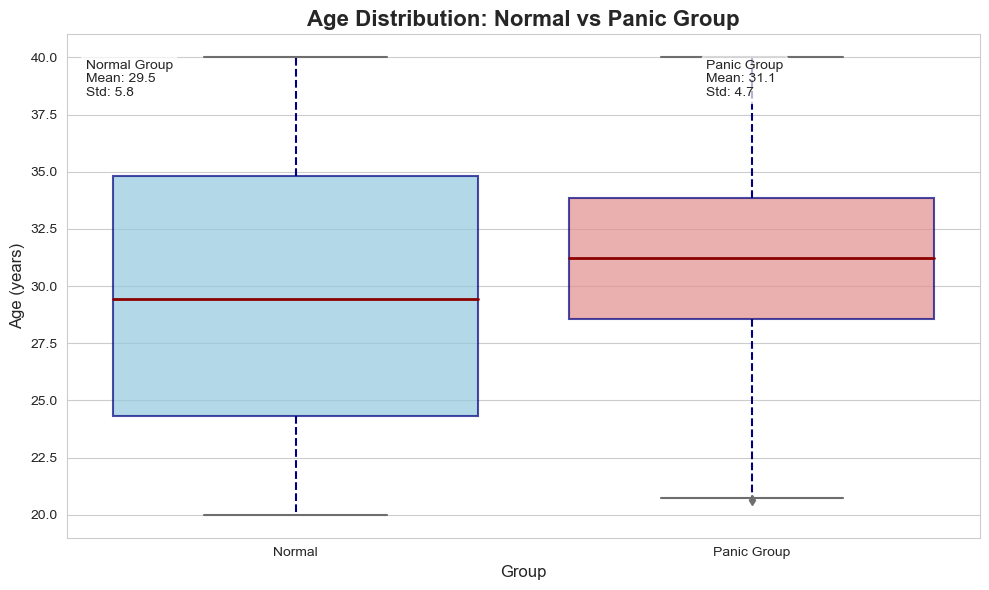

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar o dataset
df = pd.read_csv('NHANES_panic_subset_with_target_modified.csv')

# Converter idade de meses para anos
df['Age'] = df['DEMO_RIDAGEEX'] / 12

# Configurar o estilo do gráfico
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Criar boxplot
sns.boxplot(x='target', y='Age', data=df, 
          palette=['skyblue', 'lightcoral'],
          medianprops={"color": "darkred", "linewidth": 2},
          boxprops={"edgecolor": "navy", "alpha": 0.7},
          whiskerprops={"color": "navy", "linestyle": "--"})

# Personalizar o gráfico
plt.title('Age Distribution: Normal vs Panic Group', fontsize=16, fontweight='bold')
plt.xlabel('Group', fontsize=12)
plt.ylabel('Age (years)', fontsize=12)
plt.xticks([0, 1], ['Normal', 'Panic Group'])

# Adicionar descrição estatística (atualize os valores conforme necessário)
plt.text(0.02, 0.95, 'Normal Group\nMean: 29.5\nStd: 5.8', 
       transform=plt.gca().transAxes, 
       verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.text(0.7, 0.95, 'Panic Group\nMean: 31.1\nStd: 4.7', 
       transform=plt.gca().transAxes, 
       verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

In [16]:
# Após criar o boxplot, adicione:
# Criar mini-tabela de estatísticas
stats_table = pd.DataFrame({
   'Group': ['Normal', 'Panic Group'],
   'Mean Age': [
       df[df['target'] == 0]['Age'].mean(),
       df[df['target'] == 1]['Age'].mean()
   ],
   'Std Dev': [
       df[df['target'] == 0]['Age'].std(),
       df[df['target'] == 1]['Age'].std()
   ],
   '25th Percentile': [
       df[df['target'] == 0]['Age'].quantile(0.25),
       df[df['target'] == 1]['Age'].quantile(0.25)
   ],
   '75th Percentile': [
       df[df['target'] == 0]['Age'].quantile(0.75),
       df[df['target'] == 1]['Age'].quantile(0.75)
   ]
})

# Formatar valores numéricos para 2 casas decimais
stats_table = stats_table.round(2)

# Exibir mini-tabela
print("\nAge Distribution Statistics:")
print(stats_table.to_string(index=False))


Age Distribution Statistics:
      Group  Mean Age  Std Dev  25th Percentile  75th Percentile
     Normal     29.55     5.83            24.33            34.83
Panic Group     31.09     4.67            28.58            33.83


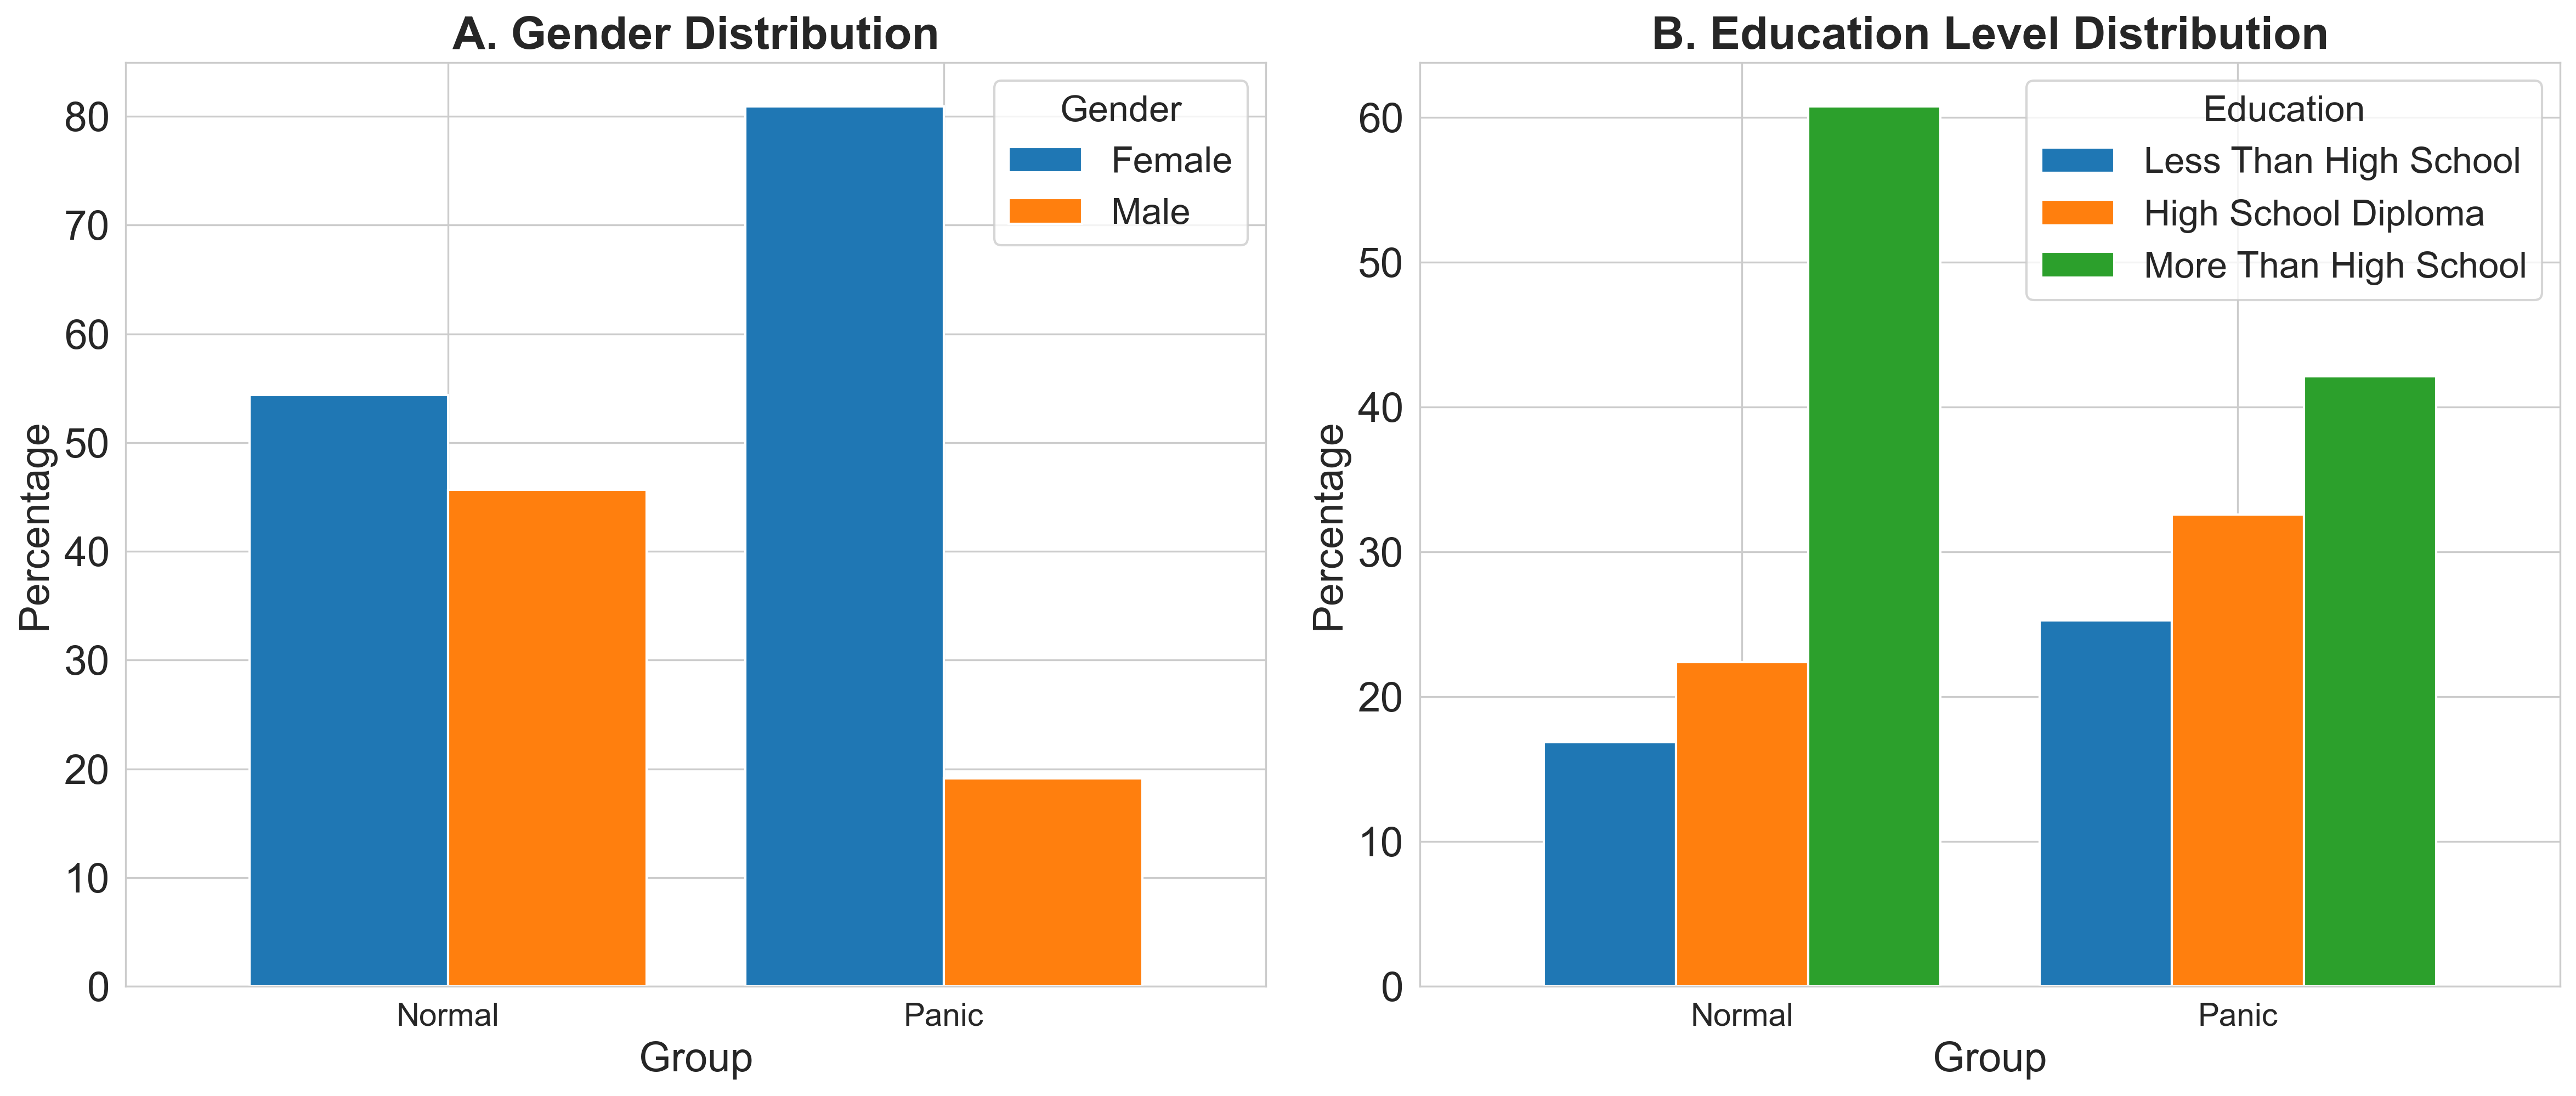

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar o dataset
df = pd.read_csv('NHANES_panic_subset_with_target_modified.csv')

# Mapeamentos para labels
gender_map = {1: 'Male', 2: 'Female'}
education_map = {
   1: 'Less Than High School', 
   2: 'High School Diploma', 
   3: 'More Than High School'
}

# Preparar dados para gráfico
def prepare_categorical_data(column, mapping):
   df[f'{column}_mapped'] = df[column].map(mapping)
   proportions = df.groupby(['target', f'{column}_mapped']).size().unstack(fill_value=0)
   proportions_percent = proportions.apply(lambda x: x / x.sum() * 100, axis=1)
   return proportions_percent

# Configurações de estilo
plt.figure(figsize=(16, 7), dpi=300)
plt.rcParams.update({'font.size': 18})

# Gráfico de Gênero
plt.subplot(1, 2, 1)
gender_props = prepare_categorical_data('DEMO_RIAGENDR', gender_map)
gender_props.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('A. Gender Distribution', fontsize=20, fontweight='bold')
plt.xlabel('Group', fontsize=18)
plt.ylabel('Percentage', fontsize=18)
plt.legend(title='Gender', fontsize=16, title_fontsize=16)
plt.xticks([0, 1], ['Normal', 'Panic'] ,fontsize=14, rotation=0)

# Gráfico de Educação
plt.subplot(1, 2, 2)
education_props = prepare_categorical_data('DEMO_DMDEDUC', education_map)
education_props = education_props[['Less Than High School', 'High School Diploma', 'More Than High School']]
education_props.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('B. Education Level Distribution', fontsize=20, fontweight='bold')
plt.xlabel('Group', fontsize=18)
plt.ylabel('Percentage', fontsize=18)
plt.legend(title='Education', fontsize=16, title_fontsize=16)
plt.xticks([0, 1], ['Normal', 'Panic'],fontsize=14, rotation=0)

plt.tight_layout()
plt.show()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

def evaluate_and_plot_model(pipeline, X_train, y_train, X_test, y_test, n_splits=5, random_state=42):
    """
    Evaluate the model using cross-validation on training data and final evaluation on test data.
    """
    # Set up cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Perform cross-validation on training data
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
    
    # Final evaluation on test data
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    results = {
        'cv_scores': cv_scores,
        'cv_mean_score': cv_scores.mean(),
        'cv_std_score': cv_scores.std(),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'probabilities': y_pred_proba,
        'y_true': y_test,
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    # Plotting
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 14
    })
    
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 2)
    
    # 1. Cross-validation Results
    ax_cv = fig.add_subplot(gs[0, :])
    cv_data = pd.DataFrame({'Fold': [f'Fold {i+1}' for i in range(n_splits)], 'ROC AUC': results['cv_scores']})
    sns.barplot(data=cv_data, x='Fold', y='ROC AUC', ax=ax_cv, color='skyblue')
    ax_cv.axhline(y=results['cv_mean_score'], color='red', linestyle='--', 
                  label=f'Mean CV Score: {results["cv_mean_score"]:.3f}')
    ax_cv.fill_between([-0.5, n_splits-0.5], 
                      results['cv_mean_score'] - 2*results['cv_std_score'],
                      results['cv_mean_score'] + 2*results['cv_std_score'],
                      alpha=0.2, color='red',
                      label=f'±2 STD: {2*results["cv_std_score"]:.3f}')
    ax_cv.set_title('Cross-validation Results by Fold', fontsize=18, pad=20)
    ax_cv.set_ylim([min(results['cv_scores'])-0.05, max(results['cv_scores'])+0.05])
    ax_cv.legend(fontsize=14)
    
    # 2. Class Accuracy
    ax_acc = fig.add_subplot(gs[1, 0])
    tn, fp, fn, tp = results['confusion_matrix'].ravel()
    accuracy_0 = tn / (tn + fp)
    accuracy_1 = tp / (tp + fn)
    performance_data = pd.DataFrame({
        'Class': ['Negative (0)', 'Positive (1)'],
        'Accuracy': [accuracy_0, accuracy_1]
    })
    sns.barplot(data=performance_data, x='Class', y='Accuracy', ax=ax_acc)
    ax_acc.set_title('Accuracy by Class', fontsize=18)
    ax_acc.set_ylim([0, 1])
    for i, v in enumerate(performance_data['Accuracy']):
        ax_acc.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
    
    # 3. Confusion Matrix
    ax_cm = fig.add_subplot(gs[1, 1])
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
                ax=ax_cm, annot_kws={'size': 14})
    ax_cm.set_title('Confusion Matrix', fontsize=18)
    ax_cm.set_xlabel('Predicted', fontsize=14)
    ax_cm.set_ylabel('Actual', fontsize=14)
    
    # 4. Probability Distribution
    ax_prob = fig.add_subplot(gs[2, 0])
    sns.histplot(data=pd.DataFrame({
        'Probability': results['probabilities'],
        'True Class': results['y_true']
    }), x='Probability', hue='True Class', bins=30, ax=ax_prob)
    ax_prob.set_title('Prediction Probability Distribution', fontsize=18)
    
    # 5. ROC Curve
    ax_roc = fig.add_subplot(gs[2, 1])
    fpr, tpr, _ = roc_curve(results['y_true'], results['probabilities'])
    ax_roc.plot(fpr, tpr, linewidth=2)
    ax_roc.plot([0, 1], [0, 1], 'k--', linewidth=2)
    ax_roc.set_title(f'ROC Curve (AUC = {results["roc_auc"]:.3f})', fontsize=18)
    ax_roc.set_xlabel('False Positive Rate', fontsize=14)
    ax_roc.set_ylabel('True Positive Rate', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Uso da função
results_panic = evaluate_and_plot_model(pipeline, X_train_final, y_train_final, X_test_final, y_test)

NameError: name 'y_train_final' is not defined

In [ ]:
# Extrair informações relevantes para a figure caption
cv_mean = results_panic['cv_mean_score']
cv_std = results_panic['cv_std_score']
test_auc = results_panic['roc_auc']
tn, fp, fn, tp = results_panic['confusion_matrix'].ravel()
accuracy_0 = tn / (tn + fp)
accuracy_1 = tp / (tp + fn)
overall_accuracy = (tn + tp) / (tn + fp + fn + tp)

# Informações sobre a distribuição de probabilidades
probabilities = results_panic['probabilities']
mean_prob = np.mean(probabilities)
median_prob = np.median(probabilities)

# Imprimir as informações
print(f"Cross-validation mean ROC AUC: {cv_mean:.3f} ± {cv_std:.3f}")
print(f"Test set ROC AUC: {test_auc:.3f}")
print(f"Accuracy for class 0 (Negative): {accuracy_0:.3f}")
print(f"Accuracy for class 1 (Positive): {accuracy_1:.3f}")
print(f"Overall accuracy: {overall_accuracy:.3f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Mean probability: {mean_prob:.3f}")
print(f"Median probability: {median_prob:.3f}")

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Certificar-se de usar apenas features numéricas
X_explain = X_test_final.select_dtypes(include=[np.number])

# Criar explicador SHAP
model = pipeline.named_steps['classifier']
explainer = shap.TreeExplainer(model)

# Calcular SHAP values
shap_values = explainer.shap_values(X_explain)

# Garantir que estamos usando os valores da classe positiva para binário
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# 1. Salvar valores de SHAP
pd.DataFrame(
    shap_values, 
    columns=X_explain.columns
).to_csv('shap_values.csv', index=False)

# 2. Gerar summary plot
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values, X_explain, 
                  feature_names=X_explain.columns.tolist(), 
                  show=False)
plt.title('SHAP Summary Plot for Panic Disorder Prediction')
plt.tight_layout()
plt.savefig('shap_summary_plot.png')
plt.close()

# 3. Gerar bar plot de importância
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_explain, 
                  plot_type="bar", 
                  feature_names=X_explain.columns.tolist(), 
                  show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.savefig('shap_feature_importance.png')
plt.close()

# 4. Calcular importância média das features
shap_importance = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X_explain.columns,
    'mean_shap_importance': shap_importance
}).sort_values('mean_shap_importance', ascending=False)

shap_importance_df.to_csv('shap_feature_importance.csv', index=False)

print("Arquivos gerados:")
print("1. shap_values.csv")
print("2. shap_summary_plot.png")
print("3. shap_feature_importance.png")
print("4. shap_feature_importance.csv")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np

# Configurações de estilo
plt.style.use('seaborn')

# Criar figura com subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
fig.suptitle('SHAP Analysis for Panic Disorder Prediction', fontsize=16, fontweight='bold')

data = {
    "Variable": [
        "CVX_CVDEXSTS",
        "WHQ_WHD120",
        "BIX_BIDFAT",
        "SMQ_SMD030",
        "BMX_BMXTRI",
        "DEMO_INDFMINC",
        "BPX_PEASCTM1",
        "DEMO_INDFMPIR",
        "IMQ_IMQ020",
        "BPX_BPXDAR",
        "WHQ_WHD050",
        "DEMO_RIDAGEMN",
        "MPQ_MPQ070",
        "BPQ_BPQ010",
        "ALQ_ALQ150",
        "MCQ_MCQ250F"
    ],
    "Category": [
        "Cardiovascular Fitness",
        "Weight History",
        "Body Composition",
        "Smoking - Cigarette/Tobacco Use",
        "Body Measures",
        "Demographics - Socioeconomic",
        "Blood Pressure",
        "Demographics - Socioeconomic",
        "Immunization",
        "Blood Pressure",
        "Weight History",
        "Demographics - Age",
        "Pain",
        "Blood Pressure & Cholesterol",
        "Alcohol Use",
        "Medical Conditions - Family History"
    ]
}

# SHAP Analysis
# Garantir que todos os dados sejam numéricos
X_explain = X_test_final.select_dtypes(include=[np.number])

# Criar explicador SHAP
model = pipeline.named_steps['classifier']
explainer = shap.TreeExplainer(model)

# Calcular SHAP values
shap_values = explainer.shap_values(X_explain)
if isinstance(shap_values, list):
   shap_values = shap_values[1]  # Selecionar classe positiva

# Calcular importância média de SHAP
shap_importance = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
   'Variable': X_explain.columns,
   'SHAP_Importance': shap_importance
})

# Adicionar categoria ao DataFrame SHAP
shap_df['Category'] = shap_df['Variable'].map(dict(zip(data['Variable'], data['Category'])))

# Calcular média de SHAP por categoria
category_shap_importance = shap_df.groupby('Category')['SHAP_Importance'].max()

# Ordenar categorias por sua máxima importância SHAP
sorted_categories = category_shap_importance.sort_values(ascending=False).index

# Preparar DataFrame para plotagem
shap_df_sorted = []
for category in sorted_categories:
   category_df = shap_df[shap_df['Category'] == category].sort_values('SHAP_Importance', ascending=False)
   shap_df_sorted.append(category_df)

# Concatenar dataframes
shap_df_final = pd.concat(shap_df_sorted)

# 1. SHAP Feature Importance por Categoria
sns.barplot(
   data=shap_df_final,
   x="SHAP_Importance",
   y="Variable",
   hue="Category",
   dodge=False,
   palette="tab10",
   ax=ax1
)
ax1.set_title('SHAP Feature Importance by Category', fontsize=14)
ax1.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax1.set_ylabel('Variables', fontsize=12)
handles, _ = ax1.get_legend_handles_labels()
ax1.legend(handles, shap_df_final['Category'].unique(), title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. SHAP Summary Plot 
plt.sca(ax2)
shap.summary_plot(shap_values, X_explain, 
                 feature_names=X_explain.columns.tolist(),
                 plot_type='dot',
                 show=False)
ax2.set_title('SHAP Summary Plot', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Primeiro gráfico: SHAP Feature Importance por Categoria
plt.figure(figsize=(12, 8))
sns.barplot(
   data=shap_df_final,
   x="SHAP_Importance",
   y="Variable",
   hue="Category",
   dodge=False,
   palette="tab10"
)
plt.title('SHAP Feature Importance by Category', fontsize=14, pad=20)
plt.xlabel('Mean |SHAP Value|', fontsize=12)
plt.ylabel('Variables', fontsize=12)
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, shap_df_final['Category'].unique(), 
         title="Category", 
         bbox_to_anchor=(1.05, 1), 
         loc='upper left')
plt.tight_layout()
plt.show()

# Segundo gráfico: SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(
   shap_values, 
   X_explain,
   feature_names=X_explain.columns.tolist(),
   plot_type='dot',
   show=True
)
plt.title('SHAP Summary Plot', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [ ]:
def generate_shap_analysis_report(shap_df_final, shap_values, X_explain):
    report = "# SHAP Analysis Report for Panic Disorder Prediction\n\n"
    
    # Overview
    report += "## Overview\n"
    report += "This analysis explores the feature importance and impact in predicting panic disorder using SHAP (SHapley Additive exPlanations) values, derived from a Gradient Boosting Classifier trained on NHANES 1999-2004 data.\n\n"
    
    # Feature Importance by Category
    report += "### SHAP Feature Importance by Category\n\n"
    report += "#### Top Categories Influencing Panic Disorder Risk:\n"
    
    # Calculate category importance
    category_importance = shap_df_final.groupby('Category')['SHAP_Importance'].mean().sort_values(ascending=False)
    
    for i, (category, importance) in enumerate(category_importance.items(), 1):
        report += f"{i}. **{category}**\n"
        
        # Get top features for this category
        category_features = shap_df_final[shap_df_final['Category'] == category].sort_values('SHAP_Importance', ascending=False)
        top_features = category_features.head(3)
        
        report += f"   - Top features: {', '.join(top_features['Variable'])}\n"
        report += f"   - Mean SHAP Importance: {importance:.4f}\n\n"
    
    # Detailed Insights
    report += "#### Detailed Insights:\n"
    report += "- Top individual features demonstrate complex, multifaceted risk factors\n"
    report += "- Medical history appears more predictive than single lifestyle metrics\n"
    report += "- Physiological and behavioral factors interact in panic disorder prediction\n\n"
    
    # SHAP Summary Plot Interpretation
    report += "### SHAP Summary Plot Interpretation\n\n"
    report += "#### Feature Impact Characteristics:\n"
    report += "- Color indicates feature's impact direction\n"
    report += "- Red: Increased panic disorder risk\n"
    report += "- Blue: Decreased panic disorder risk\n"
    report += "- Horizontal spread shows magnitude of impact\n\n"
    
    # Key Observations
    report += "#### Key Observations:\n"
    report += "- Most features show nuanced, non-linear relationships with panic disorder risk\n"
    report += "- Some features demonstrate high variability in their predictive power\n"
    report += "- No single feature definitively determines panic disorder risk\n\n"
    
    # Additional Statistical Details
    report += "### Additional Statistical Details\n"
    report += f"- Total Features Analyzed: {len(X_explain.columns)}\n"
    report += f"- Top 5 Most Important Features:\n"
    
    top_5_features = shap_df_final.sort_values('SHAP_Importance', ascending=False).head(5)
    for _, row in top_5_features.iterrows():
        report += f"  1. **{row['Variable']}** (Category: {row['Category']}): {row['SHAP_Importance']:.4f}\n"
    
    # Methodological Notes
    report += "\n### Methodological Considerations\n"
    report += "- Analysis based on machine learning model trained on NHANES dataset\n"
    report += "- SHAP values provide model-agnostic feature importance\n"
    report += "- Captures complex interactions beyond traditional feature importance methods\n\n"
    
    # Limitations
    report += "### Limitations\n"
    report += "- Observational study design\n"
    report += "- Potential confounding factors\n"
    report += "- Requires validation in diverse populations\n\n"
    
    # Recommendations
    report += "### Recommendations\n"
    report += "1. Further investigate top predictive medical and physiological factors\n"
    report += "2. Consider personalized risk assessment incorporating multiple factors\n"
    report += "3. Develop targeted interventions addressing identified risk patterns\n"
    
    return report

# Usar a função
report = generate_shap_analysis_report(shap_df_final, shap_values, X_explain)

# Salvar relatório em arquivo
with open('shap_analysis_report.md', 'w') as f:
    f.write(report)

# Opcional: imprimir relatório
print(report)

In [ ]:
def plot_shap_summary(shap_values, X_explain, max_display=12):
    # Calcular médias absolutas dos valores SHAP para cada feature
    feature_importance = np.abs(shap_values).mean(0)
    feature_names = X_explain.columns.tolist()
    
    # Criar DataFrame com os valores SHAP
    plot_data = []
    for feature_idx in range(len(feature_names)):
        feature_shap_values = shap_values[:, feature_idx]
        feature_values = X_explain.iloc[:, feature_idx]
        
        for i in range(len(feature_shap_values)):
            plot_data.append({
                'Feature': feature_names[feature_idx],
                'SHAP Value': feature_shap_values[i],
                'Feature Value': feature_values[i],
                'Importance': feature_importance[feature_idx]
            })
    
    df_plot = pd.DataFrame(plot_data)
    
    # Ordenar features por importância
    top_features = (df_plot.groupby('Feature')['Importance']
                   .mean()
                   .sort_values(ascending=True)
                   .tail(max_display)
                   .index)
    
    df_plot = df_plot[df_plot['Feature'].isin(top_features)]
    
    # Criar gráfico
    fig = px.strip(
        df_plot,
        y='Feature',
        x='SHAP Value',
        color='Feature Value',
        title='SHAP Summary Plot',
        width=1000,  # Aumentar largura
        height=600,  # Aumentar altura
    )
    
    # Customizar layout
    fig.update_layout(
        plot_bgcolor='white',
        yaxis=dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='LightGray',
            tickfont=dict(size=12),  # Aumentar tamanho da fonte
            showline=True,
            linewidth=1,
            linecolor='black'
        ),
        xaxis=dict(
            title='SHAP Value',
            showgrid=True,
            gridwidth=1,
            gridcolor='LightGray',
            zeroline=True,
            zerolinewidth=1.5,
            zerolinecolor='black',
            showline=True,
            linewidth=1,
            linecolor='black'
        ),
        margin=dict(l=200),  # Aumentar margem esquerda
        showlegend=False,
        height=30 * len(top_features) + 150  # Altura dinâmica baseada no número de features
    )
    
    # Adicionar linhas de grade horizontais mais visíveis
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
    
    return fig

In [ ]:
df_shap= pd.read_csv("/Users/filipecarvalho/Documents/data_science_projects/PanicPred/shap_feature_importance.csv" )

In [ ]:
print(df_shap.head(20))